# Multi-ConvNet Architectures

In this notebook, we concatenate *multiple parallel convolutional nets together* to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [1]:
import pandas as pd

import keras
from keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model # new! pip install tensorflow
from keras.layers import Input, concatenate # new! 
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
#keras , tensorflow , scikit-learn , matplotlib , nltk

#### Set hyperparameters

In [3]:
# output directory name:
output_dir = 'model_output/multiconv'

# training:
epochs = 100
batch_size = 32

# vector-space embedding: 
n_dim = 64
n_unique_words = 1581 
max_review_length = 106
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# convolutional layer architecture:
n_conv_1 = n_conv_2 = n_conv_3 = 256 
k_conv_1 = 3
k_conv_2 = 2
k_conv_3 = 4

# dense layer architecture: 
n_dense = 256
dropout = 0.2

#### Load data

In [4]:
dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)

In [5]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Error loading stopwords: <urlopen error Tunnel connection
[nltk_data]     failed: 407 Proxy Authentication Required>


In [6]:
li_stopwords = stopwords.words('english')

In [7]:
word_to_remove = ['against','up','down','under','no','nor','not',
                  'wasn',"wasn't",'weren',"weren't",'won',"won't",
                  'wouldn',"wouldn't",'aren',"aren't",'couldn',"couldn't",
                  'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',
                  "hasn't",'haven',"haven't",'isn',"isn't"]
li_stopwords = [words for words in li_stopwords if words not in word_to_remove]

In [8]:
corpus = []
for i in range(0, 1000):
    review = re.sub('[^a-zA-Z]', ' ', dataset['Review'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in li_stopwords]
    review = ' '.join(review)
    corpus.append(review)

In [9]:
list_word = []
count = 0
dict_word = {}
for i in corpus:
    for x in i.split():
        if(x not in list_word):
            list_word.append(x)
            dict_word[x] = count
            count += 1


In [10]:
max_len = 0
for i in corpus:
    if len(i) > max_len:
        max_len = len(i)

In [11]:
max_len

106

In [12]:
list_word[1564]

'problem'

In [13]:
list_review = []
for i in corpus:
    temp = []
    for x in i.split():
        temp.append(dict_word[x])
    list_review.append(temp)
    

In [14]:
len(dict_word)

1581

In [15]:
list_review

[[0, 1, 2],
 [3, 4, 5],
 [4, 6, 7, 8],
 [9, 10, 11, 12, 13, 14, 15, 16, 1],
 [17, 18, 19, 20],
 [21, 22, 23, 24, 25],
 [26, 27, 28, 29],
 [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41],
 [42, 19],
 [19, 43],
 [44, 45],
 [46, 4, 47, 48],
 [49, 50, 51, 52, 53, 54, 55, 36, 56, 57],
 [58, 59, 60, 61, 62, 63, 64],
 [65, 66, 67, 68, 69],
 [70, 50, 71, 72, 73],
 [74, 16],
 [75, 76, 77, 44],
 [2, 4, 78, 38, 79, 80, 81],
 [4, 31],
 [82, 83],
 [84, 85],
 [44, 86, 87],
 [33, 51, 88, 89, 90],
 [91],
 [92, 93, 94, 95, 96, 97, 5],
 [98, 99, 100, 101],
 [102, 103, 19, 104, 105, 106, 107, 108],
 [109, 110, 21, 84, 111, 112, 84, 113, 114, 115, 116, 117, 31, 118, 119],
 [120, 121, 122],
 [86, 123, 31, 124, 42, 125, 126, 127],
 [31, 128, 129],
 [130, 2, 131, 33, 4, 132],
 [133, 31, 5, 134, 2, 135, 136, 137, 138, 84, 139, 140, 141],
 [142, 31, 2, 143],
 [144, 145, 112, 146],
 [147, 148, 5, 20],
 [149, 44, 150, 35, 151, 31, 152, 153, 38, 154, 111],
 [155, 156, 157, 158],
 [44, 159],
 [160, 161, 162],
 [4

In [16]:
import numpy as np
X = np.array(list_review)
y = dataset.iloc[:, 1].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, random_state = 0)

C:\Users\gaura\AppData\Local\Temp\ipykernel_18608\2914869697.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(list_review)


In [17]:
x_train

array([list([497, 207, 1252, 398, 1253, 836]),
       list([86, 28, 835, 1075, 1076, 1077, 864, 1078, 595, 85, 1079, 262]),
       list([375, 44, 788, 414]),
       list([39, 140, 38, 637, 957, 256, 702, 54, 50, 84]),
       list([308, 1393, 29, 629, 1394, 628]), list([62, 25, 28, 332]),
       list([1, 2]), list([615, 21]), list([990, 4, 251, 47, 48]),
       list([863, 1405]), list([207, 412, 161]),
       list([62, 274, 263, 1180, 1181, 1182, 667, 642]),
       list([149, 44, 150, 35, 151, 31, 152, 153, 38, 154, 111]),
       list([709, 81, 530, 21, 367, 250]),
       list([23, 155, 53, 178, 19, 937, 44]),
       list([370, 111, 400, 210, 130, 610, 898, 1573, 100]), list([2, 5]),
       list([517, 19, 145, 518]), list([160, 161, 162]),
       list([19, 84, 19, 44, 496, 107, 721]),
       list([807, 617, 2, 525, 124, 194, 577, 230, 529, 28, 1384, 233, 281, 233]),
       list([846, 613, 31, 98, 425, 411, 84, 302]),
       list([1546, 106, 66, 8, 537, 698]), list([44, 4, 36, 725, 666])

#### Preprocess data

In [18]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [19]:
# start with conv_1 only and no concat
# add conv_2
# add conv_3
# add dense_2

input_layer = Input(shape=(max_review_length,), dtype='int16', name='input') # supports integers +/- 32.7k 
embedding_layer = Embedding(n_unique_words, n_dim, input_length=max_review_length, name='embedding')(input_layer)
drop_embed_layer = SpatialDropout1D(drop_embed, name='drop_embed')(embedding_layer)

conv_1 = Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

conv_2 = Conv1D(n_conv_2, k_conv_2, activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

conv_3 = Conv1D(n_conv_3, k_conv_3, activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)

concat = concatenate([maxp_1, maxp_2, maxp_3])

dense_layer = Dense(n_dense, activation='relu', name='dense')(concat)
drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)
dense_2 = Dense(64, activation='relu', name='dense_2')(drop_dense_layer)
dropout_2 = Dropout(dropout, name='drop_dense_2')(dense_2)

predictions = Dense(1, activation='sigmoid', name='output')(dropout_2)

model = Model(input_layer, predictions)

In [20]:
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 106)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 106, 64)      101184      ['input[0][0]']                  
                                                                                                  
 drop_embed (SpatialDropout1D)  (None, 106, 64)      0           ['embedding[0][0]']              
                                                                                                  
 conv_1 (Conv1D)                (None, 104, 256)     49408       ['drop_embed[0][0]']             
                                                                                              

#### Configure model

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [23]:
# start with conv_1 only and no concat: 89.1% validation accuracy in epoch 2, as earlier notebook
# add conv_2: 89.5% in epoch 3
# add conv_3: ditto
# add dense_2: ditto in epoch 2
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/100
25/25 [==============================] - 6s 147ms/step - loss: 0.6908 - accuracy: 0.5013 - val_loss: 0.6815 - val_accuracy: 0.6100
Epoch 2/100
25/25 [==============================] - 3s 113ms/step - loss: 0.5963 - accuracy: 0.7300 - val_loss: 0.5193 - val_accuracy: 0.7400
Epoch 3/100
25/25 [==============================] - 3s 110ms/step - loss: 0.2659 - accuracy: 0.9038 - val_loss: 0.5270 - val_accuracy: 0.7850
Epoch 4/100
25/25 [==============================] - 3s 128ms/step - loss: 0.1048 - accuracy: 0.9613 - val_loss: 0.5788 - val_accuracy: 0.7900
Epoch 5/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0335 - accuracy: 0.9900 - val_loss: 0.7128 - val_accuracy: 0.7850
Epoch 6/100
25/25 [==============================] - 1s 23ms/step - loss: 0.0283 - accuracy: 0.9900 - val_loss: 0.7575 - val_accuracy: 0.7800
Epoch 7/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0217 - accuracy: 0.9912 - val_loss: 0.8713 - val_accuracy: 0.7950
Ep

Epoch 58/100
25/25 [==============================] - 1s 25ms/step - loss: 7.6469e-04 - accuracy: 1.0000 - val_loss: 2.1827 - val_accuracy: 0.8000
Epoch 59/100
25/25 [==============================] - 1s 25ms/step - loss: 3.5612e-04 - accuracy: 1.0000 - val_loss: 2.1605 - val_accuracy: 0.8100
Epoch 60/100
25/25 [==============================] - 1s 25ms/step - loss: 7.0250e-05 - accuracy: 1.0000 - val_loss: 2.1767 - val_accuracy: 0.8000
Epoch 61/100
25/25 [==============================] - 1s 25ms/step - loss: 1.2694e-04 - accuracy: 1.0000 - val_loss: 2.1939 - val_accuracy: 0.8000
Epoch 62/100
25/25 [==============================] - 1s 25ms/step - loss: 1.4922e-04 - accuracy: 1.0000 - val_loss: 2.2151 - val_accuracy: 0.8000
Epoch 63/100
25/25 [==============================] - 1s 25ms/step - loss: 1.3706e-04 - accuracy: 1.0000 - val_loss: 2.2329 - val_accuracy: 0.8050
Epoch 64/100
25/25 [==============================] - 1s 25ms/step - loss: 1.0799e-04 - accuracy: 1.0000 - val_loss: 2

#### Evaluate

In [36]:
model.load_weights(output_dir+"/weights.73.hdf5") # zero-indexed

In [25]:
y_hat = model.predict(x_valid)

7/7 [==============================] - 0s 7ms/step


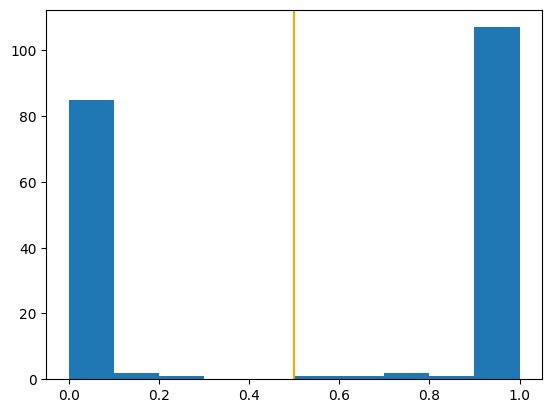

In [26]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [27]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'86.95'

In [28]:
review_input = input()

Crust is not good.


In [29]:
review_custom = re.sub('[^a-zA-Z]', ' ', review_input)
review_custom = review_custom.lower()
review_custom = review_custom.split()
ps = PorterStemmer()
review_custom = [ps.stem(word) for word in review_custom]
review_custom = ' '.join(review_custom)

In [30]:
review_custom

'crust is not good'

In [31]:
custom_list = []
custom_test = []
for x in review_custom.split():
    if(x in dict_word.keys()):
        custom_test.append(dict_word[x])
custom_list.append(custom_test)

In [32]:
custom_list = np.array(custom_list)
custom_list

array([[3, 4, 5]])

In [33]:
custom_list = pad_sequences(custom_list, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [34]:
pred_1 = model.predict(custom_list)

1/1 [==============================] - 0s 17ms/step


In [37]:
if(pred_1[0][0] < 0.8):
    print(0)
else:
    print(1)

0


In [43]:
round(pred_1[0][0],2)

0.0

In [53]:
for i,j in zip(y_hat,y_valid):
    print(round(i[0],2),"->",j)

0.0 -> 0
0.0 -> 0
0.96 -> 0
0.0 -> 0
0.0 -> 0
0.01 -> 0
1.0 -> 1
0.0 -> 0
0.0 -> 0
1.0 -> 1
1.0 -> 1
1.0 -> 1
0.0 -> 0
1.0 -> 1
1.0 -> 1
1.0 -> 1
0.0 -> 0
0.0 -> 0
0.0 -> 0
1.0 -> 1
0.01 -> 0
0.04 -> 1
1.0 -> 1
1.0 -> 0
1.0 -> 0
1.0 -> 1
0.92 -> 1
1.0 -> 1
1.0 -> 1
0.0 -> 0
1.0 -> 1
1.0 -> 1
1.0 -> 1
0.09 -> 1
1.0 -> 1
0.0 -> 0
0.0 -> 0
0.0 -> 0
0.01 -> 0
1.0 -> 1
1.0 -> 1
1.0 -> 0
1.0 -> 1
0.01 -> 0
0.0 -> 0
0.0 -> 0
1.0 -> 0
0.3 -> 0
0.0 -> 0
0.0 -> 0
1.0 -> 1
1.0 -> 1
0.91 -> 1
1.0 -> 1
0.0 -> 0
1.0 -> 0
0.08 -> 1
1.0 -> 1
0.0 -> 0
1.0 -> 1
1.0 -> 0
0.0 -> 0
0.02 -> 0
1.0 -> 0
1.0 -> 1
0.0 -> 0
1.0 -> 1
0.15 -> 1
1.0 -> 1
0.0 -> 0
1.0 -> 1
1.0 -> 1
1.0 -> 1
0.0 -> 1
0.0 -> 0
0.0 -> 0
1.0 -> 1
1.0 -> 1
0.0 -> 0
1.0 -> 1
0.0 -> 0
1.0 -> 1
1.0 -> 1
0.0 -> 0
1.0 -> 1
1.0 -> 1
1.0 -> 0
1.0 -> 0
1.0 -> 1
1.0 -> 0
0.0 -> 0
1.0 -> 1
0.0 -> 0
0.0 -> 0
0.0 -> 0
1.0 -> 1
0.0 -> 0
1.0 -> 1
0.98 -> 1
0.18 -> 0
0.09 -> 1
1.0 -> 1
1.0 -> 1
1.0 -> 0
0.0 -> 1
0.69 -> 0
1.0 -> 1
1.0 -> 1
0.0 -> 0
0.9

In [61]:
test_Acc = [1 if round(i[0],2) > 0.8 else 0 for i in y_hat]


In [63]:
wrong_num = 0
for i,j in zip(test_Acc,y_valid):
    if(i!= j):
        wrong_num += 1
        

In [64]:
wrong_num

37

In [65]:
len(test_Acc)

200